In [15]:
import os
import re
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
# Function to count keywords in a text
def count_keywords(text, keywords):
    # Counter object to count occurrences of each keyword
    counts = Counter()
    for keyword in keywords:
        # Count occurrences of the keyword in the text
        counts[keyword] = text.lower().count(keyword)
    return counts

def agg_keywords(df, col_title, keywords):
    # Aggregate 'extracted_sentences' for each 'title' and count keywords
    results = {}
    for title, group in df.groupby('title'):
        # Combine all extracted sentences into one large text block
        aggregated_text = " ".join(group[col_title].tolist())
        # Count the keywords in this aggregated text
        keyword_counts = count_keywords(aggregated_text, keywords)
        # Store the result
        results[title] = keyword_counts

    # Convert the results dictionary to a DataFrame 
    results_df = pd.DataFrame.from_dict(results, orient='index')
    return results_df

In [3]:
# Convert counts to binary values
def convert_to_binary_values(df):
    columns_to_convert = df.columns.tolist()

    # Convert to binary: 1 if the count is greater than 0, else 0
    for column in columns_to_convert:
        df[column] = df[column].apply(lambda x: 1 if x > 0 else 0)
    
    return df

In [4]:
# Reverse the mapping for aggregation
def agg_columns_to_categories(df, keyword_to_category):
    category_to_keywords = {}
    for keyword, category in keyword_to_category.items():
        category_to_keywords.setdefault(category, []).append(keyword)

    # Aggregate columns into categories
    for category, keywords in category_to_keywords.items():
        if category in df.columns:
            # If the category already exists, add to it
            df[category] += df[keywords].sum(axis=1)
        else:
            # Otherwise, create a new column for the category
            df[category] = df[keywords].sum(axis=1)
        # Drop the original keyword columns
        df.drop(columns=keywords, inplace=True)

    return df

In [30]:
# Mapping of keywords to main categories
keyword_to_category = {
    'age'   : 'age_',
    'gender': 'gender_',
    'sex'   : 'gender_',
    'female': 'gender_',
    'women' : 'gender_',
    'woman' : 'gender_',
    'male'  : 'gender_',
    'geolocation'   : 'geolocation_',
    'geographical'  : 'geolocation_',
    'geographic'    : 'geolocation_',
    'country'       : 'geolocation_',
    'countries'     : 'geolocation_',
    'city'          : 'geolocation_',
    'cities'        : 'geolocation_',
    'hospital'      : 'geolocation_',
    'hospitals'     : 'geolocation_',
    'clinic'        : 'geolocation_',
    'clinics'       : 'geolocation_',
    'society'       : 'social factors',
    'societies'     : 'social factors',
    'etnicity'      : 'etnicity_',
    'etnicities'    : 'etnicity_',
    'race'          : 'etnicity_',
    'bias'          : 'bias_',
    'biases'        : 'bias_',
    'unfair'        : 'fairness_',
    'fair'          : 'fairness_',
    'fairness'      : 'fairness_',
    'transparency'  : 'fairness_',
    'awareness'     : 'fairness',
    'imbalance'     : 'fairness_',
    'imbalanced'    : 'fairness_',
    'balance'       : 'fairness_',
    'balanced'      : 'fairness_',
    'problem'       : 'concerns',
    'problems'      : 'concerns',
    'issue'         : 'concerns',
    'issues'        : 'concerns',
    'challenge'     : 'concerns',
    'challenges'    : 'concerns',
    'difficult'     : 'concerns',
    'difficulty'    : 'concerns',
    'difficulties'  : 'concerns'
}

***

In [31]:
# List of keywords
keywords_demographics_long = [
    'age', 'gender', 'sex', 'women', 'woman', 'female', 'male',
    'geolocation', 'geographical', 'geographic', 'country', 'countries', 'city', 'cities', 
    'hospital', 'hospitals', 'clinic', 'clinics', 'society', 'societies',
    'etnicity', 'etnicities', 'race', 
    'bias', 'biases', 'fair', 'unfair', 'fairness', 'transparency', 'awareness',
    'imbalance', 'imbalanced', 'balance', 'balanced',
    'problem', 'problems', 'issue', 'issues', 'challenge', 'challenges', 
    'difficult', 'difficulty', 'difficulties']

# List of keywords
keywords_demographics_short = [
    'age', 'gender', 'sex', 'women', 'woman', 'female', 'male',
    'etnicity', 'etnicities', 'race', 
    'bias', 'biases', 'fair', 'unfair', 'fairness', 'transparency', 
    'imbalance', 'imbalanced', 'balance', 'balanced']

In [32]:
filename = '/Users/yasminsarkhosh/Documents/GitHub/machine-learning-bsc-thesis-2024/code/outputs/data/extracted_sentences.csv'
extracted_df = pd.read_csv(filename, index_col=0)
extracted_df

,title,extracted_keyword_sent
0,Anatomy-Driven Pathology Detection on Chest X-...,none
1,Self-supervised Learning for Physiologically-B...,none
2,AME-CAM: Attentive Multiple-Exit CAM for Weakl...,"to address this\nissue, recent research has fo..."
3,AME-CAM: Attentive Multiple-Exit CAM for Weakl...,"to meet this need, many researchers\nhave devo..."
4,AME-CAM: Attentive Multiple-Exit CAM for Weakl...,our proposed method has the following\ncontrib...
...,...,...
313,Trackerless Volume Reconstruction from Intraop...,liver cancer is the most prevalent indication ...
314,Trackerless Volume Reconstruction from Intraop...,such motion is predominant in the context high...
315,CoLa-Diff: Conditional Latent Diffusion Model ...,it shows superiority in model training however...
316,CoLa-Diff: Conditional Latent Diffusion Model ...,-propose an auto-weight\nadaptation to balance...


In [33]:
# Store keyword-match for extracted sentences

# Load the DataFrame from the uploaded file
df = extracted_df

# List of keywords
keywords = keywords_demographics_long

# Initialize columns for each keyword with default value 0
for keyword in keywords:
    df[keyword] = 0

# Function to update the keyword columns based on matches
def update_keyword_columns(row):
    text = row['extracted_keyword_sent']  # Assuming this column holds the extracted sentences
    for keyword in keywords:
        # Update the column for the keyword if it's found in the text
        if keyword in text:
            row[keyword] = 1
    return row

# Apply the function to each row in the DataFrame
df = df.apply(update_keyword_columns, axis=1)
df.head()  # Display the first few rows of the updated DataFrame

# Save the updated DataFrame, if needed
df.to_csv('extracted_sentences_keyword_counts.csv', index=False)

In [34]:
# Count the number of occurrences of each keyword in the extracted sentences
keyword_counts = agg_keywords(df, 'extracted_keyword_sent', keywords)
keyword_counts.to_csv('total_keyword_counts.csv', index=True)

In [35]:
# Aggregate the keywords into categories and aggregate the counts by category
refined_keyword_counts_by_categories = agg_columns_to_categories(keyword_counts, keyword_to_category)
refined_keyword_counts_by_categories.to_csv('refined_keyword_counts_by_categories.csv')


In [36]:
# Convert the counts to binary values for each category
binary_keyword_counts_by_categories =  convert_to_binary_values(refined_keyword_counts_by_categories)
binary_keyword_counts_by_categories.to_csv('binary_keyword_counts_by_categories.csv')

***
## Functions for data visualisations
***

In [37]:
# Plotting the number of category-related keywords in papers 
def plot_category(category, df):
    df[category].value_counts().plot(kind='bar')
    plt.title('Number of Papers Discussing ' + category)
    plt.xlabel('Mentions of ' + category + '-Related Keywords')
    plt.ylabel('Number of Papers')
    plt.show()

In [38]:
# Subplotting the number of category-related keywords in papers
def subplot_categories_binary(categories_to_plot, agg_results_df):
    # Define the number of rows and columns for the subplots based on the number of categories
    num_categories = len(categories_to_plot)
    num_cols = 3  # Choose the number of columns for your subplot grid
    num_rows = num_categories // num_cols + (num_categories % num_cols > 0)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 3 * num_rows))  # Adjust figsize as necessary
    axs = axs.flatten()  # Flatten the array of axes for easier iteration

    total_papers = len(agg_results_df)  # The total number of papers
    
    # Plot a bar plot for each specified category
    for i, category in enumerate(categories_to_plot):
        # Create the bar plot on the appropriate subplot
        # Note: This assumes each entry in these columns is a count. If not, adjust the plotting code accordingly.
        agg_results_df[category].value_counts().sort_index().plot(kind='bar', ax=axs[i], title=category.capitalize(), color='skyblue')
        axs[i].set_xlabel('Mentions of ' + category + '-related keywords')
        axs[i].set_xticks(ticks=[0, 1], labels=['No', 'Yes']) # Customize the x-axis tick labels

        axs[i].set_ylabel('Number of Papers')
        axs[i].set_ylim(0, 200)  # Adjust y-axis limits as necessary
        axs[i].set_title('Number of papers discussing ' + '|' + category + '|', fontsize=10, fontweight='bold', color='white', loc='center', pad=10, weight='bold')
    
        # Add a horizontal line at the total number of papers
        axs[i].axhline(y=total_papers, color='r', linestyle='--', label='papers in total')

        # Add legend to the subplot
        axs[i].legend(loc='lower left', fontsize=8)

    # Hide any unused subplot axes
    for j in range(i + 1, num_rows * num_cols):
        axs[j].set_visible(False)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

In [39]:
def plot_category_percentage_binary(df):    
    # Drop non-category columns
    df_categories = df.drop(df.columns[0], axis=1)

    # Calculate the sum for each category
    category_sums = df_categories.sum()

    # Calculate the percentage for each category
    total_papers = len(df)  # The total number of papers
    category_percentages = (category_sums / total_papers) * 100

    # Create a bar plot with percentage values
    category_percentages.plot(kind='bar', stacked=False, color='skyblue').set_ylim(0, 100) # Set the y-axis limits to 0-100
    plt.title('Category Distribution in Selected Papers', fontsize=12, fontweight='bold', color='white', loc='center', pad=10, weight='bold',
              backgroundcolor='black', ha='center')
    plt.ylabel('Percentage in Total')
    plt.show()

In [40]:
def plot_category_percentage_counts(df):    
    # Drop non-category columns
    xlabels = list(df.columns[1:])
    category_sums = df.sum()[1:]
    total_counts = category_sums.sum()

    category_percentages = []    
    total_word_count = total_counts
    for cat in category_sums:
        percentages = (cat / total_word_count) * 100
        category_percentages.append(percentages)
    
    print(category_percentages)

    # Create a bar plot with percentage values
    plt.bar(xlabels,category_percentages)
    plt.xticks(rotation=60)
    plt.ylim(0, 100) # Set the y-axis limits to 0-100
    plt.title('Keyword counts', fontsize=12, fontweight='bold', color='white', loc='center', pad=10, weight='bold',
              backgroundcolor='black', ha='center')
    plt.ylabel('Percentage in Total')
    plt.show()

In [41]:
binary_keyword_counts_by_categories.columns

Index(['age_', 'gender_', 'geolocation_', 'social factors', 'etnicity_',
       'bias_', 'fairness_', 'fairness', 'concerns'],
      dtype='object')

In [42]:
# Specify the categories you want to plot
categories_to_plot = ['age_', 'gender_', 'geolocation_', 'social factors', 
                      'etnicity_','bias_', 'fairness_', 'fairness', 'concerns']

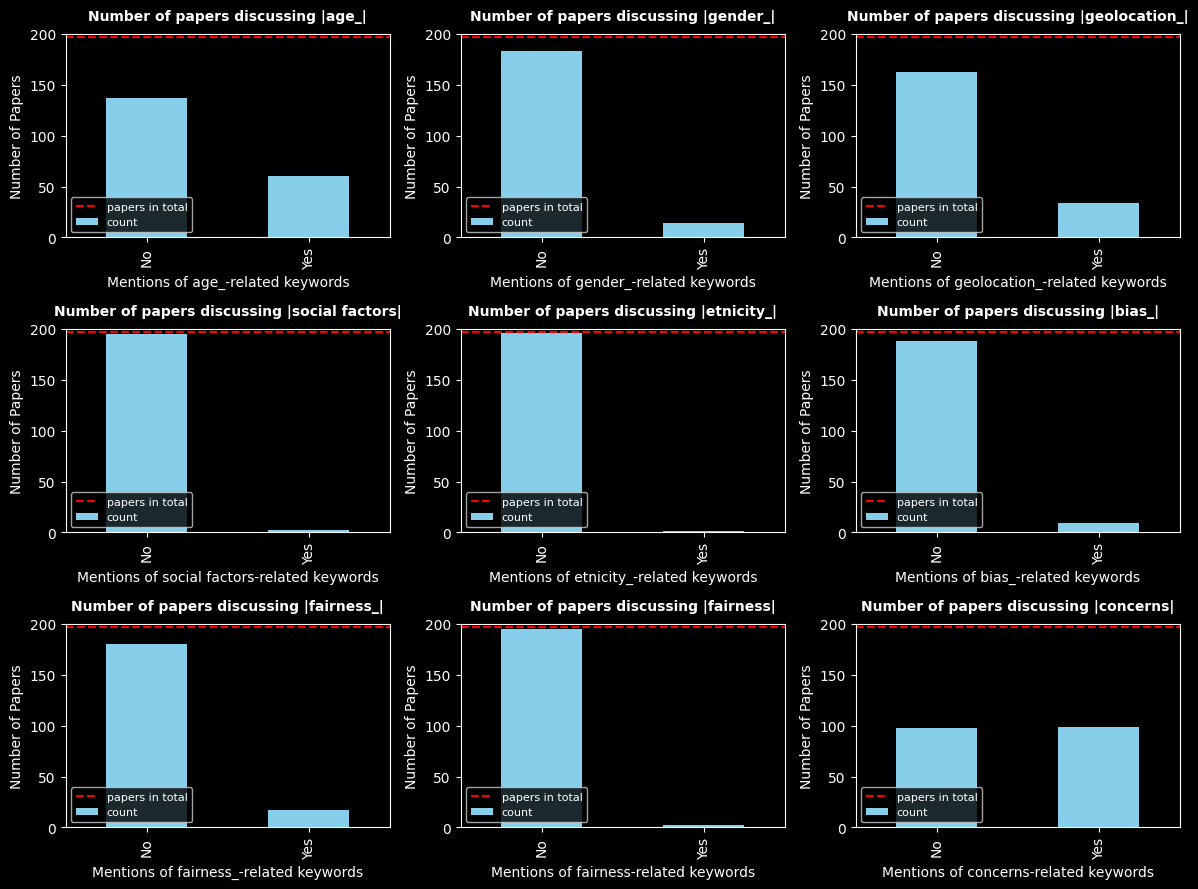

In [43]:
subplot_categories_binary(categories_to_plot, binary_keyword_counts_by_categories)

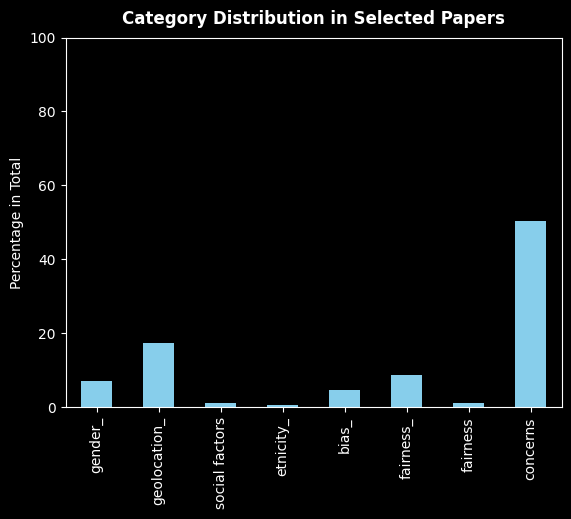

In [44]:
# By binary counts per category
plot_category_percentage_binary(binary_keyword_counts_by_categories)

[7.865168539325842, 19.101123595505616, 1.1235955056179776, 0.5617977528089888, 5.056179775280898, 9.550561797752808, 1.1235955056179776, 55.61797752808989]


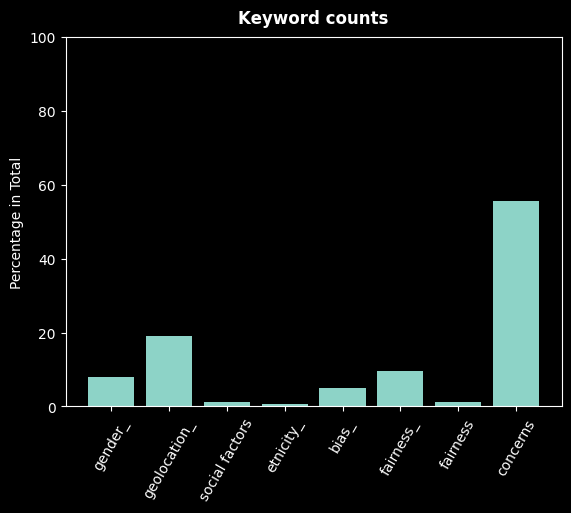

In [45]:
# By total counts per category
plot_category_percentage_counts(refined_keyword_counts_by_categories)